In [1]:
import pandas as pd
import numpy as np
# add path to the folder with the utils
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import mne
from utils.loader import load_data, unicorn_fs, convert_to_mne, unicorn_eeg_channels
%matplotlib inline
#matplotlib.use("Qt5Agg")

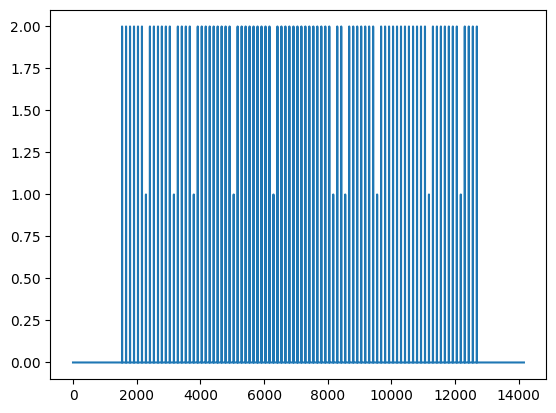

,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,STI
0,11.464,-5.232,7.073,11.797,6.470,7.098,12.784,11.407,0.0
1,14.607,-2.247,11.343,15.806,8.108,4.677,14.161,13.519,0.0
2,16.651,-1.246,14.129,19.571,8.284,2.627,13.886,14.329,0.0
3,17.567,-0.799,15.270,21.872,7.521,1.394,12.840,12.699,0.0
4,17.987,0.877,15.716,22.212,7.882,2.577,14.113,10.977,0.0
...,...,...,...,...,...,...,...,...,...
14155,1.465,7.229,3.522,6.698,4.525,-0.566,4.754,9.061,0.0
14156,-1.697,3.421,-0.123,5.005,3.913,-0.154,7.007,8.712,0.0
14157,-3.935,0.259,-3.033,2.685,2.179,-2.023,6.518,5.584,0.0
14158,-5.109,-1.538,-4.798,0.819,0.585,-3.416,5.881,1.974,0.0


In [2]:
# NOTE: skiprows=5 is needed to skip the first 5 rows of the csv file
eeg, trigger, dataframe = load_data("../data/aep/auditory_erp_eyes_closed_S1.csv", header=False, names = unicorn_eeg_channels, fs=unicorn_fs, skiprows=5)
plt.plot(trigger)
plt.show()
dataframe

'''
In this test user is provided with a constant auditory stimuli (STIM = trigger = 2, event_id = NT (Non-Target) 
which is interleaved with a different sound (STIM = trigger = 1, event_id = T (Target)).
This practice should enable the P300 component which can be observed in the EEG signal.
'''

#### Convert to MNE format
MNE is a popular Python library for EEG data analysis. It provides a simple and intuitive way to work with EEG data, and it is widely used in the scientific community. The library provides many useful tools for EEG data analysis, such as data visualization, signal processing, and machine learning. In this section, we will convert the EEG data to the MNE format, so that we can use the library to analyze the data.
Documentation: [MNE](https://mne.tools/stable/index.html)

In [3]:
# Convert to MNE format
raw_data = convert_to_mne(eeg, trigger, fs=unicorn_fs, chs=unicorn_eeg_channels, recompute=False) # recompute=True to recalculate the event labels if the values are negative

Creating RawArray with float64 data, n_channels=8, n_times=14160
    Range : 0 ... 14159 =      0.000 ...    56.636 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=14160
    Range : 0 ... 14159 =      0.000 ...    56.636 secs
Ready.


Effective window size : 8.192 (s)


C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


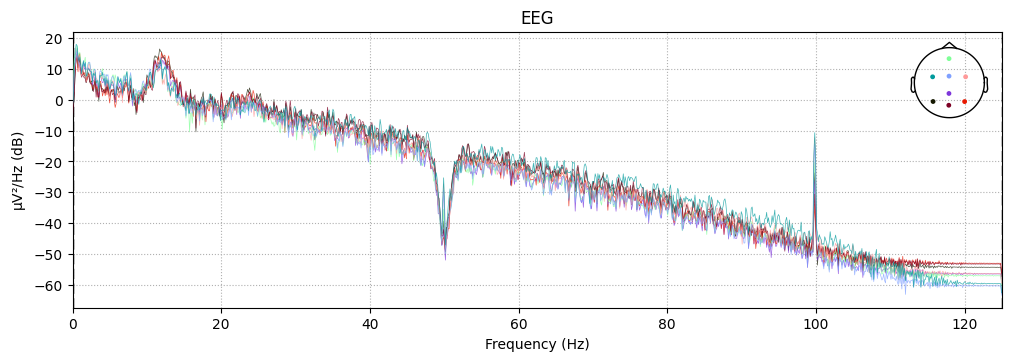

In [4]:
# Compute PSD
Pxx = raw_data.compute_psd(fmin=0, fmax=unicorn_fs/2)
Pxx.plot()
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


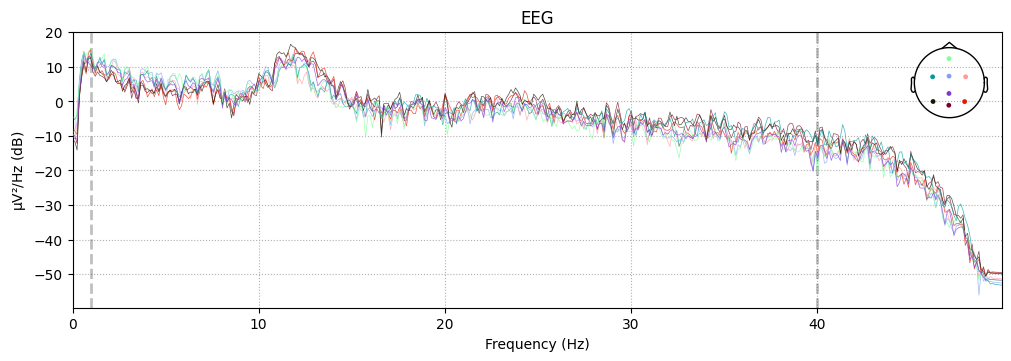

In [5]:
filtered = raw_data.copy() # the method filters the signal in-place, so this time I
                      # want to preserve the original signal and filter just a
                      # temporary copy of it

# remove power line noise
filtered.notch_filter(50) 
filtered.notch_filter(60) 
# Apply band-pass filtering
filtered.filter(1,40) 

pxx_filt = filtered.compute_psd(fmin=0, fmax=50)
pxx_filt.plot()
plt.show()

### Data Analysis


1. Mark the events with custom labels 
2. Epoching and baseline correction
3. Extract EEG data from epoch and define baseline segment.
4. Compute average P300 across epochs and channels.
5. Visualize ERPs for each channel.
6. Compute time-frequency representation using Morlet wavelets.
7. Compute power spectral density (PSD) and plot topographic map.

#### 1. Mark the events with custom labels
To extract events we need to provide the raw data and the name of the channel that contains the trigger information. The function `find_events()` will return a numpy array with the events and the event ids. We can also assign colors to the events to visualize them in the plot.

90 events found on stim channel STI
Event IDs: [1 2]
Using matplotlib as 2D backend.


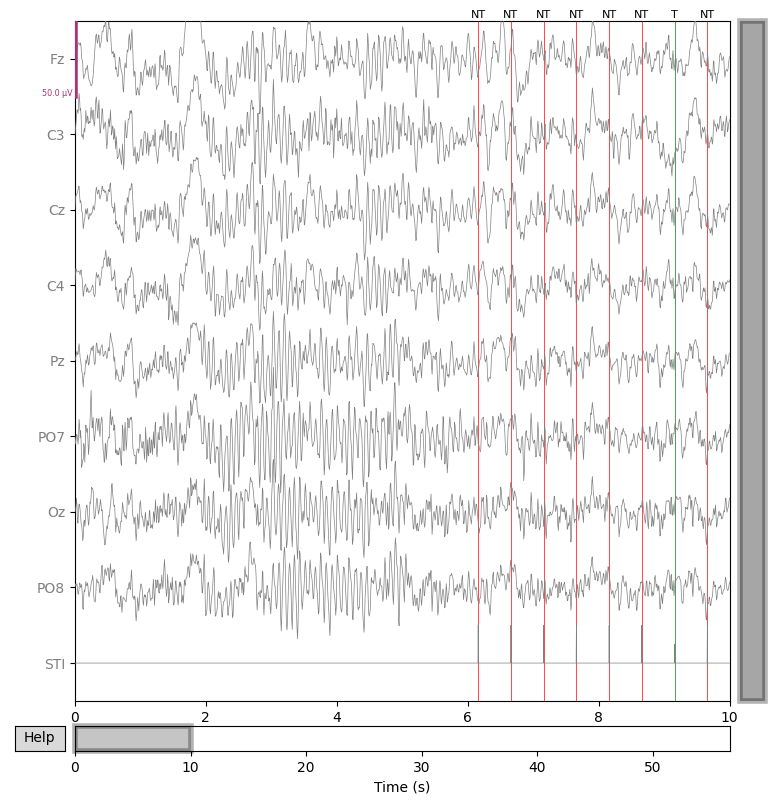

In [6]:
from mne import find_events

ev_ids = {'NT': 2, 'T':1}
event_colors = {2:'r', 1:'g'}
stim_channel = 'STI'
events = find_events(filtered, stim_channel=stim_channel)
filtered.plot(events=events, event_id=ev_ids, event_color=event_colors, color = 'Gray', block = True, clipping=None, scalings=25e-6)
plt.show()

#### 2.Epoching and baseline correction
The next step is to create the epochs. We need to provide the raw data, the events, and the event ids. We can also specify the time window for the epochs and the baseline correction. `tmin` and `tmax`  parameters define the time window extracted as single epoch relatively to the single event, `baseline` is the timespan from which the data for the baseline correction is extracted.The function `Epochs()` will return an object with the epochs.

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 351 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 351 original time points ...


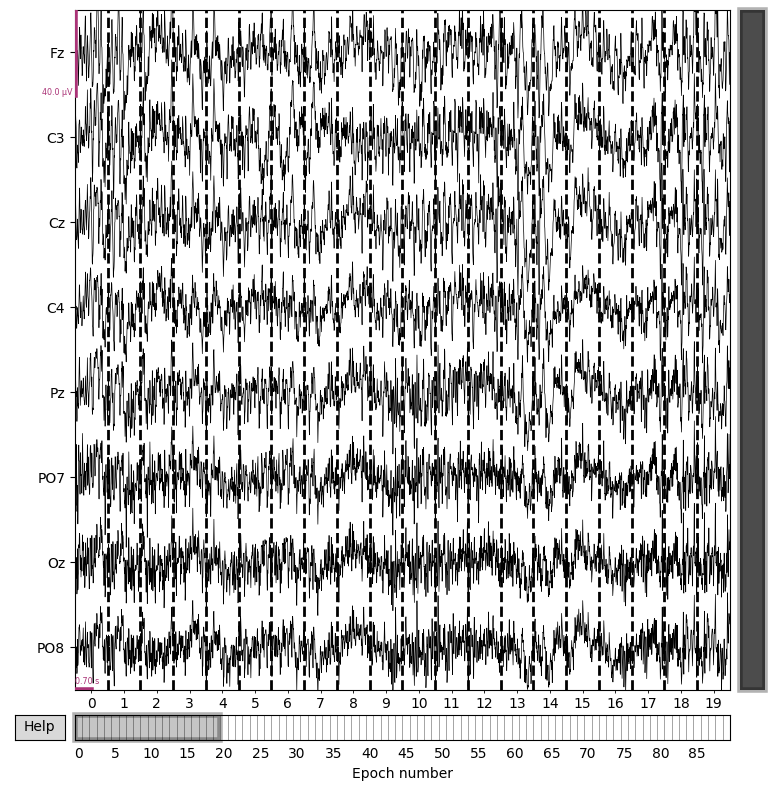

In [23]:
# creating the Epochs object combining EEG data and events info
from mne import Epochs

eps = Epochs(filtered, events, event_id=ev_ids,
             tmin=-.6, tmax=0.8, baseline=(-.6,-.1))
            
eps.plot(block=True)# .plot() method for Epoch objects has not clipping parameter
plt.show()

#### 3.Compute average P300 across epochs. 
The next step is to compute the average P300 across epochs. We can choose the target and the baseline period. The function `average()` will return an object with the average P300 across epochs.

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


C:\Users\Gianni\AppData\Local\Temp\ipykernel_13736\2769017403.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


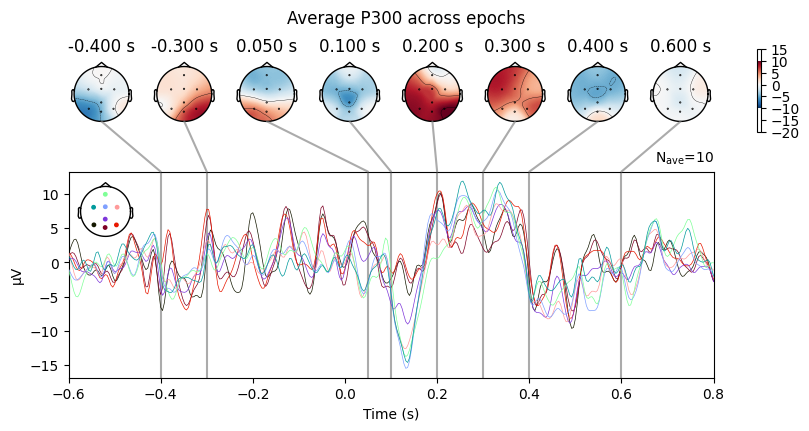

In [9]:
# Choose target
target = "T"

# Baseline period
baseline=(-.6,-.1)

# Average epochs across specified channels
average_channels = eps[target].average(picks=unicorn_eeg_channels)
average_channels.apply_baseline(baseline)
fig = average_channels.plot_joint(times=[-0.4, -0.3, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6], title="Average P300 across epochs", show=False)
fig.show()

#### 4. Visualize ERPs for each channel
The next step is to visualize the ERPs for each channel. We can choose the target and the baseline period. The function `plot()` will return a plot with the ERPs for each channel. We can also add vertical colored lines to mark the time windows of interest.

Applying baseline correction (mode: mean)
Need more than one channel to make topography for eeg. Disabling interactivity.


Applying baseline correction (mode: mean)
Need more than one channel to make topography for eeg. Disabling interactivity.
Applying baseline correction (mode: mean)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\Gianni\AppData\Local\Temp\ipykernel_13736\1088598287.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


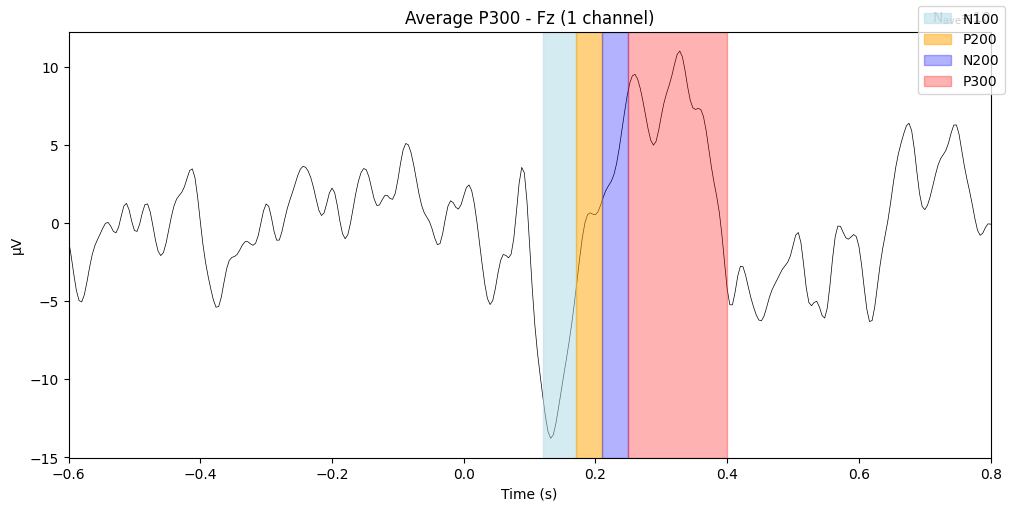

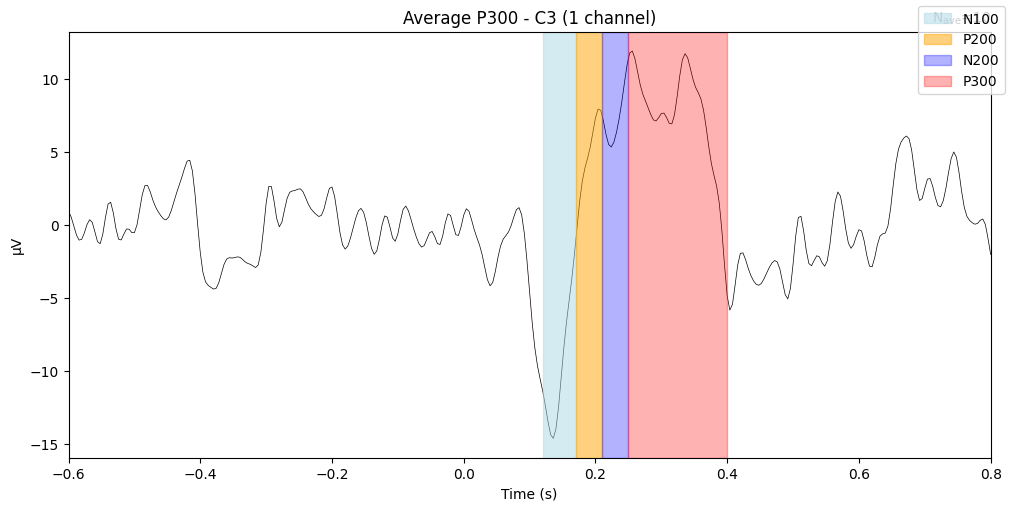

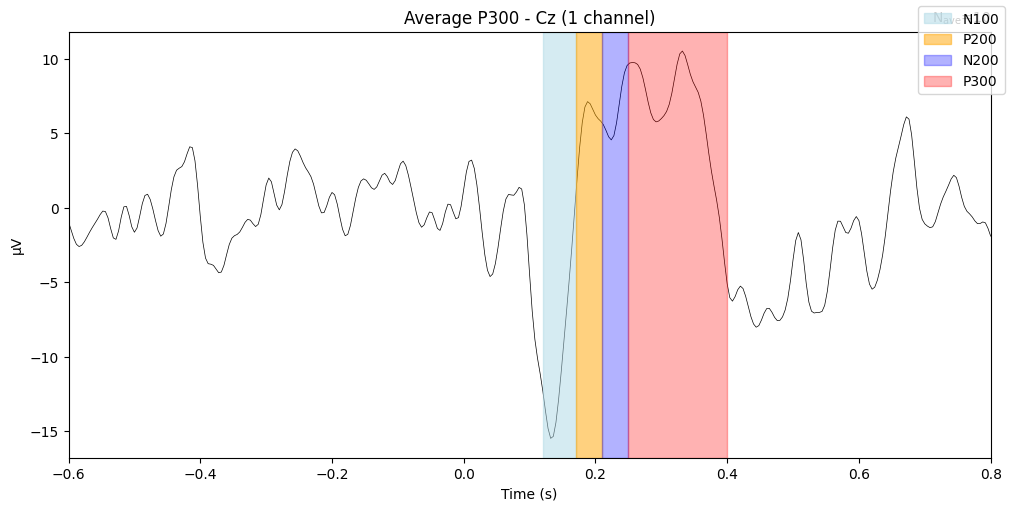

In [11]:
for channel in unicorn_eeg_channels[0:3]:
  average_epochs = eps[target].average(method="mean")
  average_epochs.apply_baseline(baseline)
  try:
      fig = average_epochs.plot(picks=channel, titles="Average P300 - " + channel, show=False)
      axes = fig.get_axes()
    
      for ax in axes:
          ax.axvspan(0.12, 0.17, color='lightblue', label="N100", alpha=0.5)
          ax.axvspan(0.17, 0.21, color='orange', label="P200", alpha=0.5)
          ax.axvspan(0.21, 0.25, color='blue', label="N200", alpha=0.3)
          ax.axvspan(0.25, 0.4, color='red', label="P300", alpha=0.3)
      fig.legend(loc='upper right', frameon=True)
      fig.set_size_inches(10, 5)
    
      # Show the plot
      fig.show()
  except Exception as e:
      print(e)

#### 5. Compute time-frequency representation using Morlet wavelets.
An alternative way to visualize the P300 is to compute the time-frequency representation using Morlet wavelets. We can choose the target and the frequency range. The function `tfr_morlet()` will return an object with the time-frequency representation.

Using data from preloaded Raw for 10 events and 351 original time points ...
Applying baseline correction (mode: mean)
No baseline correction applied


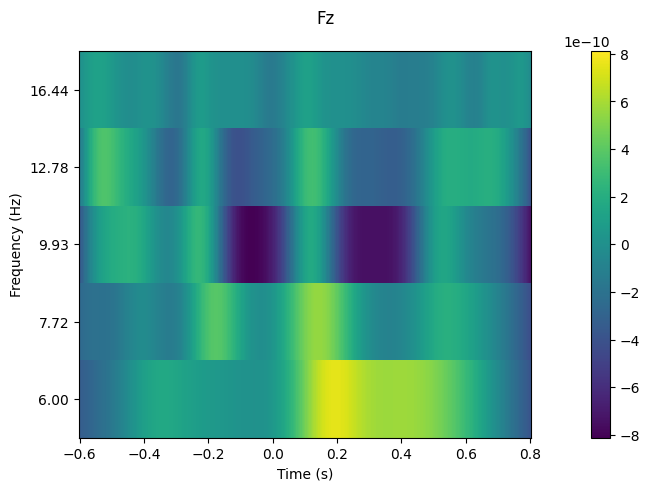

No baseline correction applied


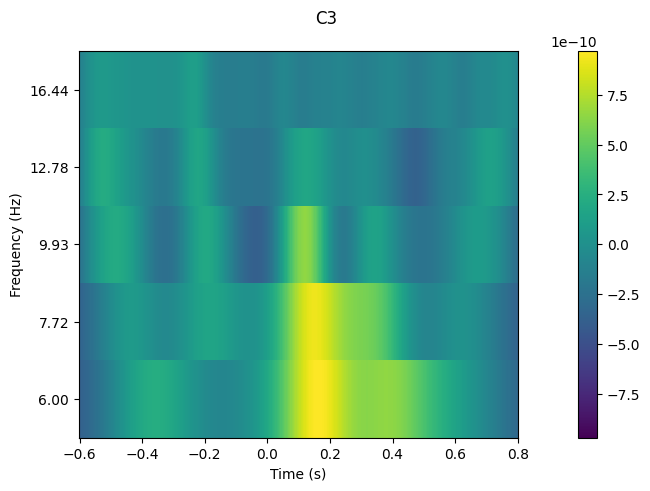

No baseline correction applied


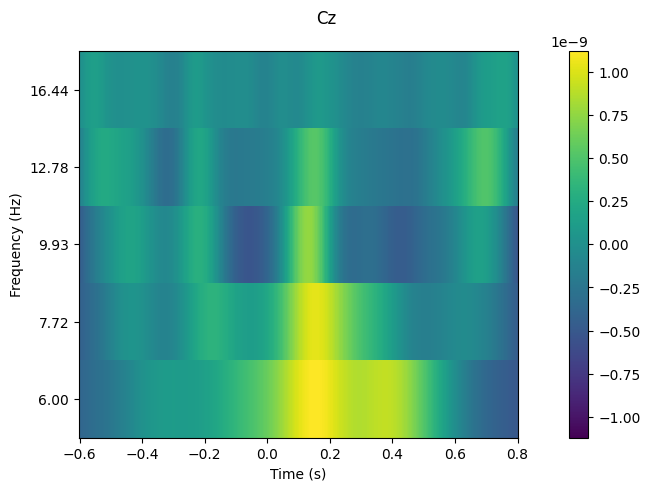

In [15]:
from mne.time_frequency import tfr_morlet
#Choose target
target = "T"

# create a time-frequency representation using Morlet wavelets
freqs = np.logspace(*np.log10([6, 35]), num=8)
tfr, itc = tfr_morlet(eps[target], freqs, n_cycles=5, average=True, return_itc=True)

# Apply baseline correction using mean power in the time range of interest
baseline=(-.6,-.1)
tfr.apply_baseline(baseline, mode='mean')

for channel in unicorn_eeg_channels[0:3]:
    try:
        tfr.plot(mode='zlogratio', picks=channel, fmin=1, fmax=20, cmap='viridis', title=channel)
        plt.show()
    except Exception as e:
        print(e)

#### 6. Compute power spectral density (PSD) and plot topographic map.
The last step is to compute the power spectral density (PSD) and plot the topographic map. We can choose the target and the frequency range. The function `compute_psd()` will return an object with the PSD. We can also plot the topographic map using the function `plot_topomap()`. The topographic map will show the distribution of the power across the scalp in each frequency band.

Using data from preloaded Raw for 10 events and 351 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (10, 8, 176), freqs shape: (176,)
    Using multitaper spectrum estimation with 7 DPSS windows


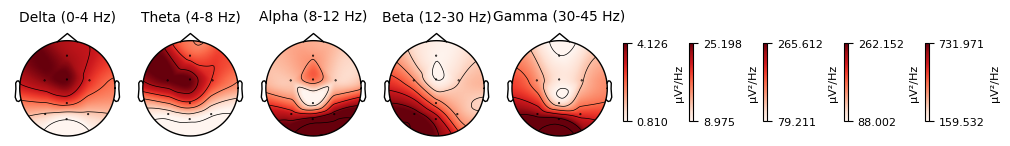

C:\Users\Gianni\AppData\Local\Temp\ipykernel_13736\2892098789.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [14]:
epo_spectrum = eps["T"].compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f'\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}')
evoked = eps["T"].average()
evk_spectrum = evoked.compute_psd()
fig = evk_spectrum.plot_topomap(ch_type='eeg', agg_fun=np.median)
fig.show()